# An End-to-End Biomedical Image Analytics Solution for Lung Nodule Classification using SAS Viya

This notebook demonstrates how to build an end-to-end solution in SAS Viya that can assist with a real-world biomedical image analytics problem, specifically lung nodule classification that is based on 3-D CT images of patient torsos and radiologist annotations of nodule locations. Lung nodules are lumps of dead tissue that commonly occur in humans, less than 5% of which are malignant. Radiologists are responsible for determining whether a nodule visually observed in a patient image is potentially cancerous so that a definitive test such as biopsy is performed for that patient. This paper focuses on nodule shape, one of many factors that radiologists account for in their classification. The basis for a shape-based classification is the irregular protrusions (called spiculations) that commonly exist on the surfaces of malignant nodules. Benign nodules, on the other hand, have smooth and spherical surfaces more often than not.

# Imports

In [1]:
import sys
stdout = sys.stdout
stderr = sys.stderr
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import struct
import swat
import swat.datamsghandlers as dmh
import time
from IPython.display import display
from mayavi import mlab
from sklearn import model_selection, metrics
from tabulate import tabulate
from IPython.display import HTML
sys.stdout = stdout
sys.stderr = stderr

%matplotlib inline

# Server and Data Locations

## CAS Server

In [2]:
cashost = '<server>'
casport = <port>

## Data Locations (Please see slides 7 and 12 below for information on data sources)

In [3]:
lcdemo_path = '<path to lung nodule data>'   # lung cancer data
caslib_name = 'lcdemo'
lcdemo_subdir = ''
slides_dir = '<path to slides>'  #slides
vhp_path = '<path to visible human data>'  #visible human data

# Helper Functions

In [4]:
def reverse(a, axis=0):
    """Reverses an numpy array along a given axis."""
    idx = [slice(None)] * len(a.shape)
    idx[axis] = slice(None, None, -1)
    return a[idx]

def display_slide(binaries, paths, width, height, n):
    """Displays nth slide."""
    slide_path = slides_dir + ('Slide%s.PNG' % n)
    pos = np.where(paths == slide_path)[0][0]
    slide_image = bytearray(binaries[pos])
    slide_image = np.reshape(slide_image, (height, width, 4))[:, :, 0:3]
    slide_image = reverse(slide_image, 2)
    plt.figure(figsize = (15, 30))
    plt.imshow(slide_image)
    plt.show()

def display_image_pair(image1, image2):
    """Displays a pair of images."""
    fig = plt.figure(figsize=(10, 10. / image1.shape[1] * image1.shape[0]))
    fig.add_subplot(121)
    plt.imshow(np.squeeze(image1))
    plt.gray()
    plt.xticks([0, image1.shape[1]], fontsize=15)
    plt.yticks([0, image1.shape[0]], fontsize=15)
    fig.add_subplot(122)
    plt.imshow(np.squeeze(image2))
    plt.gray()
    plt.xticks([0, image2.shape[1]], fontsize=15)
    plt.yticks([0, image2.shape[0]], fontsize=15)
    plt.show()

def display_image_pair_from_table(table, channels, where1, where2):
    """Fetch two images from a CAS table according to provided where-clauses and display them."""
    # Fetch image binaries, and related data
    fetched_images = table.query(where1)[['_resolution_', '_image_']]\
                                .sort_values('_path_').to_frame()
    image_resolutions = fetched_images['_resolution_']
    image_binaries = fetched_images['_image_']
    res = np.fromstring(image_resolutions[0], np.int64)
    image1 = bytearray(image_binaries[0][0:channels * res[0] * res[1]])
    image1 = np.reshape(image1, (res[1], res[0], channels))
    
    fetched_images = table.query(where2)[['_resolution_', '_image_']]\
                                .sort_values('_path_').to_frame()
    image_resolutions = fetched_images['_resolution_']
    image_binaries = fetched_images['_image_']
    res = np.fromstring(image_resolutions[0], np.int64)
    image2 = bytearray(image_binaries[0][0:channels * res[0] * res[1]])
    image2 = np.reshape(image2, (res[1], res[0], channels))
    display_image_pair(image1, image2)

def get_information(directory):
    """Get some information about files in a directory."""
    file_list = []
    for i in os.listdir(directory):
        a = os.stat(os.path.join(directory,i))
        file_list.append([i,time.ctime(a.st_mtime),time.ctime(a.st_ctime)])
    return file_list

def find_optimal_cutoff(target, predicted, plabel):
    """Find optimal cut-off based on ROC analyses."""
    fpr, tpr, threshold = metrics.roc_curve(target, predicted, pos_label=plabel)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(-tpr - (1 - fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf).argsort()[:1]]
    return list(roc_t['threshold']), fpr, tpr, threshold

def sort_label_ids_by_position(ids, paths, lbls, poss, ors, label):
    """Sort labels and ids of images according to their position."""
    inds = np.array(lbls == label)
    ids = np.array(ids)[inds]
    paths = np.array(paths)[inds]
    poss = np.array(poss)[inds]
    ors = np.array(ors)[inds]
    poss = np.array([struct.unpack('=3d', poss[i]) for i in range(poss.size)])
    ors = np.array([struct.unpack('=9d', ors[i]) for i in range(ors.size)])
    zdir = ors[0].reshape(3, 3)[:, 2]
    pros = np.array([np.dot(poss[i], zdir) for i in range(len(poss))])
    sinds = np.argsort(pros)[::-1]
    return ids[sinds], paths[sinds]

def get_image_array(image_binaries, dimensions, resolutions, formats, n):
    """Get a 3D image from CAS table."""
    dimension = dimensions[n]
    resolution = np.array(struct.unpack('=%sq' % dimension, resolutions[n][0:dimension * 8]))
    resolution = resolution[::-1]
    myformat = formats[n]
    num_cells = np.prod(resolution)
    if myformat == '16U' or myformat == '16S':
        image_array = np.array(struct.unpack('=%sh' % num_cells, image_binaries[n][0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U' or myformat == '8S':
        image_array = np.array(bytearray(image_binaries[n][0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    else:
        image_array = np.array(bytearray(image_binaries[n]))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))
        image_array = reverse(image_array, 2)
    return image_array

def mapping(val):
    """A simple mapping from int to int."""
    if (val == 0):
        return 2
    elif (val == 2):
        return 0
    else:
        return val

def display_slice_3d(images, dims, ress, fmts, poss, oris, scas, perm, image_index, slice_index, rf):
    """Display an image slice in 3D."""
    image = get_image_array(images, dims, ress, fmts, image_index)
    geo_perm = np.zeros(3, dtype=np.int)
    for i in range(3):
        geo_perm[mapping(i)] = mapping(perm[i])
    image = np.transpose(image, perm)
    image = image[slice_index, :, :]
    nr, nc = image.shape[:2]
    dimension = dims[image_index]
    pos = np.array(struct.unpack('=%sd' % dimension, poss[image_index]))
    sca = np.array(struct.unpack('=%sd' % dimension, scas[image_index][0:8 * dimension]))
    ori = np.array(struct.unpack('=%sd' % (dimension*dimension), oris[image_index][0:8 * dimension * dimension]))
    xx, yy = np.meshgrid(np.linspace(0, nc, nc), np.linspace(0, nr, nr))
    zz = np.zeros((nr, nc))
    lc = np.vstack((np.reshape(xx, (1, nc*nr)), np.reshape(yy, (1, nc*nr)), np.reshape(zz, (1, nc*nr))))
    ori = np.reshape(ori, (3, 3))
    ori = ori[:, geo_perm]
    sca = sca[geo_perm]
    pos = pos + slice_index * sca[2] * ori[:, 2]
    pos = np.reshape(pos, (3, 1))
    sca = np.diag(sca)
    gc = np.matmul(ori, np.matmul(sca, lc))
    gc = gc + np.matmul(pos, np.ones((1, nc*nr)))
    mlab.mesh(np.reshape(gc[0, :], (nr, nc)), np.reshape(gc[1, :], (nr, nc)), np.reshape(gc[2, :], (nr, nc)), 
              scalars = image, colormap='gray')
    if (rf):
        for i in range(3):
            clr=((i == 0) * 1, (i == 1) * 1, (i == 2) * 1)
            mlab.quiver3d(pos[0], pos[1], pos[2], ori[0, i], ori[1, i], ori[2, i], 
                          line_width=5, scale_factor=50*sca[i, i], color=clr, mode='arrow')

def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir, casout=casout, decode=True)
    fetched_slides = casout[['_resolution_', '_image_', '_path_']].to_frame()
    slide_binaries = fetched_slides['_image_']
    slide_resolutions = fetched_slides['_resolution_']
    slide_paths = fetched_slides['_path_']
    res = np.fromstring(slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height

# Connect to CAS Server

In [5]:
s = swat.CAS(cashost, casport)

s.loadactionset('image')
s.loadactionset('biomedimage')

s.addcaslib(name=caslib_name, path=lcdemo_path)
s.setsessopt(caslib=caslib_name, logflushtime=0)

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: 'lcdemo' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'lcdemo'.
NOTE: 'lcdemo' is now the active caslib.


+ Elapsed: 0.00082s, user: 0.001s, mem: 0.282mb

# Load Slides

NOTE: Loaded 23 images from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/ax2017d/ into Cloud Analytic Services table slides.


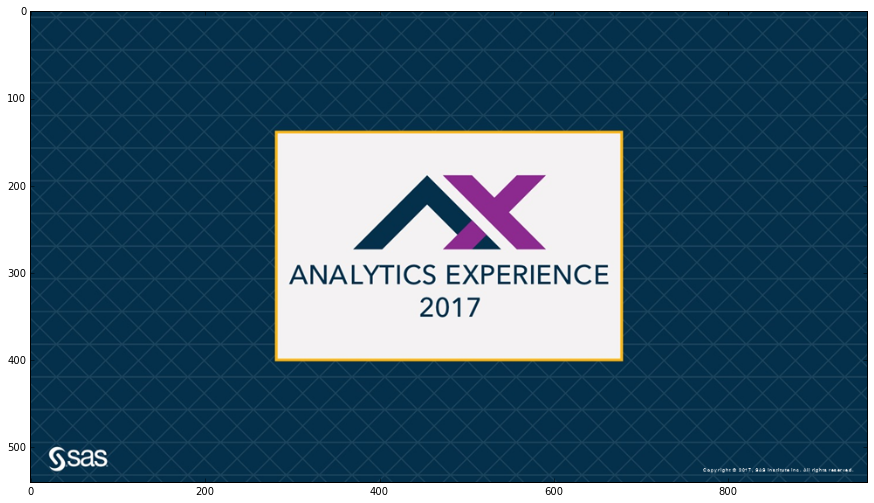

In [6]:
slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, 'slides')
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 0)

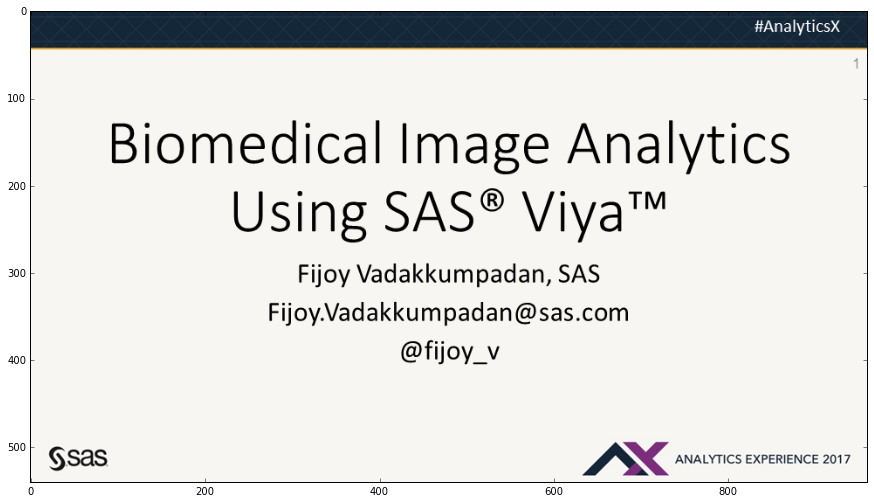

In [7]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 1)

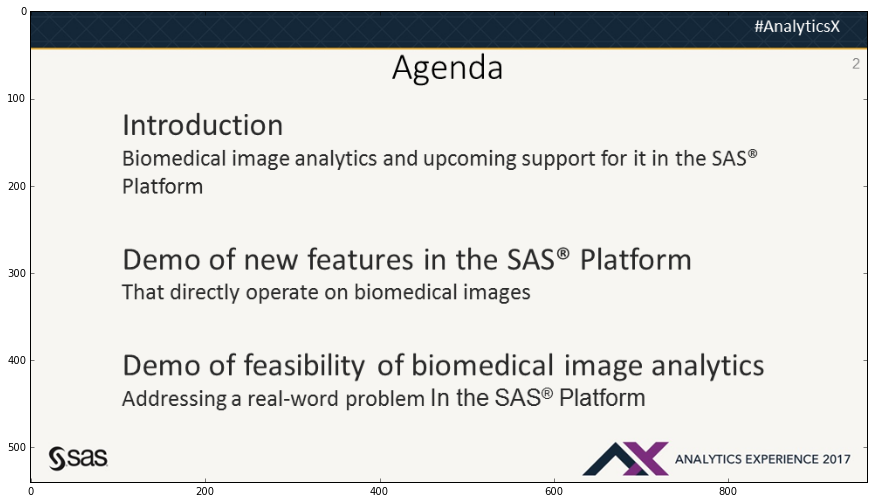

In [8]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 2)

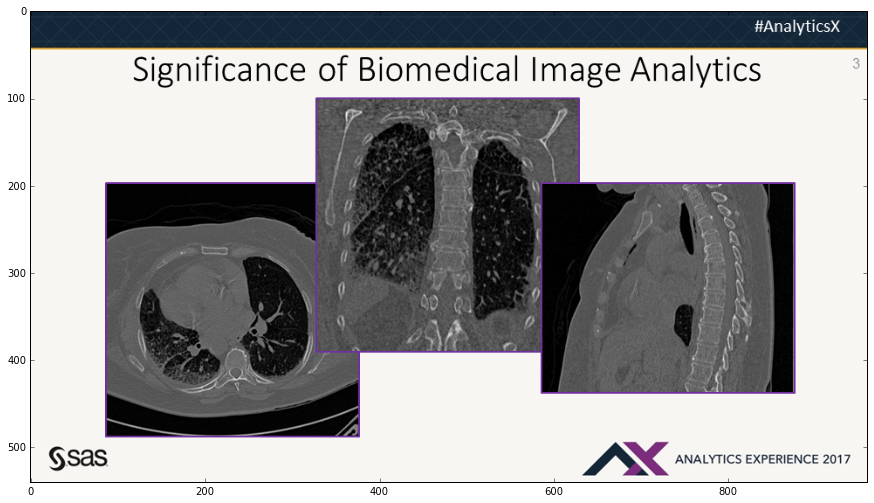

In [9]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 3)

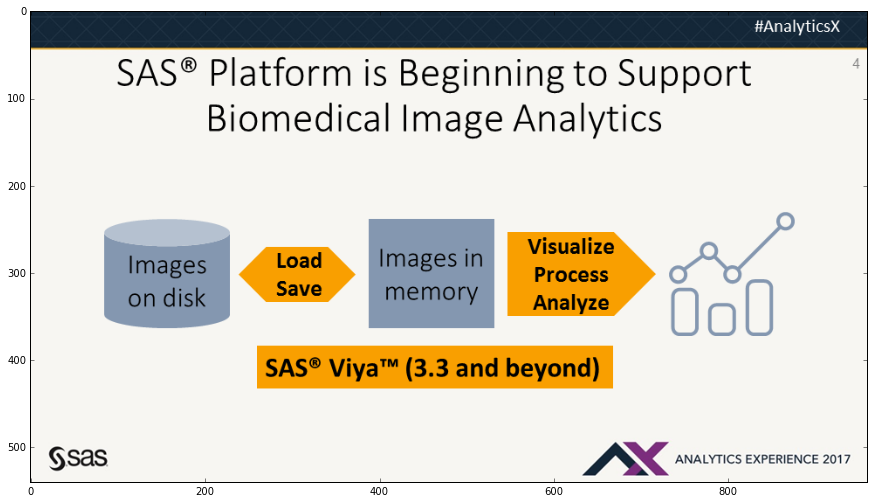

In [10]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 4)

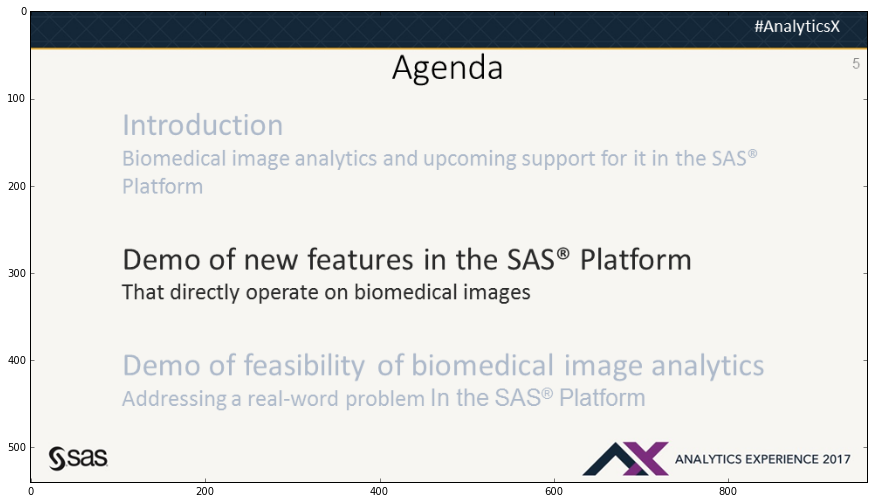

In [11]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 5)

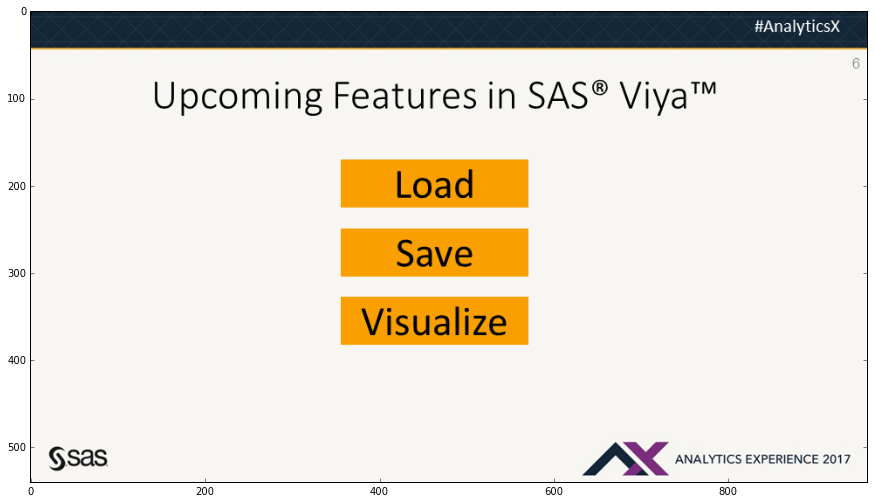

In [12]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 6)

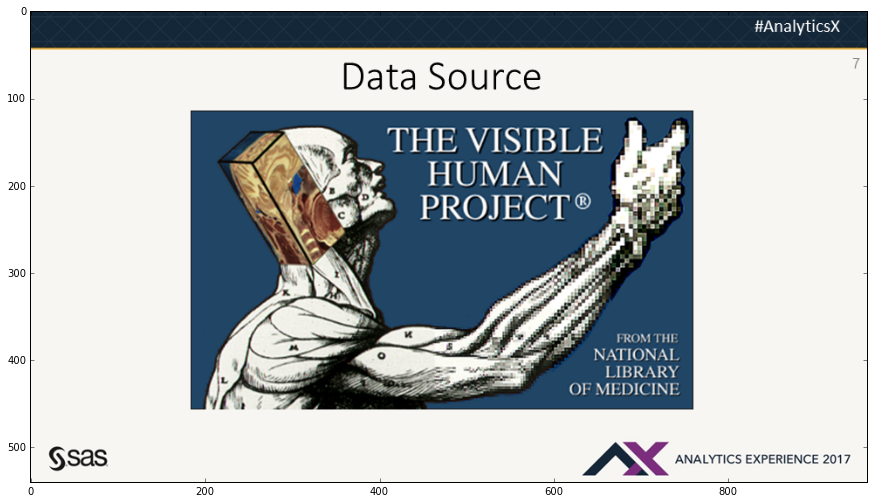

In [13]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 7)

# Load Biomedical Images & Display Metadata: 3D CT Images from Visible Human Project

## Load Images

In [14]:
# Load all image in the Visible Human directory
vhp = s.CASTable('vhp', replace=True)
s.image.loadimages(path=vhp_path,
                   casout=vhp,
                   addcolumns=['width', 'height', 'depth', 'channeltype', 'spacing'],
                   recurse=True,
                   decode=True)

NOTE: Loaded 3 images from /dept/fvcc/BMIData/DemoData/VisibleHuman/ into Cloud Analytic Services table vhp.


+ Elapsed: 0.34s, user: 0.064s, sys: 0.032s, mem: 27.8mb

## Fetch Images and Display Metadata

In [15]:
vhp_rows = vhp[['_path_', '_channelType_', '_width_', '_height_', '_depth_', '_spacing_']].to_frame()

vhp_spacings = vhp_rows['_spacing_']
vhp_n = len(vhp_rows)

spa=[[], [], []]
for i in range(vhp_n):
    spa[i] = ["%.2f" % v for v in struct.unpack("=3d", vhp_spacings[i])]

vhp_rows['_spacing_'] = spa
vhp_rows['_path_'] = vhp_rows['_path_'].str.replace(vhp_path, '')
vhp_rows

Selected Rows from Table VHP

                     _path_ _channelType_  _width_  _height_  _depth_  \
0     Male/frozenCTHead.nii           16S       93       119       57   
1    Male/frozenCTTorso.img           16S       64        45      166   
2  Female/frozenCTAnkle.nii           16S      163       236       75   

            _spacing_  
0  [2.10, 2.10, 4.04]  
1  [4.22, 4.22, 2.67]  
2  [1.00, 1.00, 2.00]

# Fetch & Display Image of the Ankle in Orthogonal View Planes (Using Mayavi)

In [16]:
# Fetch & display the head image
vhp_rows = vhp.query("_path_ = '%s%s'" % (vhp_path, 'Female/frozenCTAnkle.nii')).to_frame()

medical_dimensions = vhp_rows['_dimension_']
medical_formats = vhp_rows['_channelType_']
medical_binaries = vhp_rows['_image_']
medical_resolutions = vhp_rows['_resolution_']
medical_channel_types = vhp_rows['_channelType_']
medical_image_array = get_image_array(medical_binaries, medical_dimensions, medical_resolutions, medical_formats, 0)

sf = mlab.pipeline.scalar_field(medical_image_array)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes', slice_index=10, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes', slice_index=100, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', slice_index=50, colormap='gray')
mlab.show()

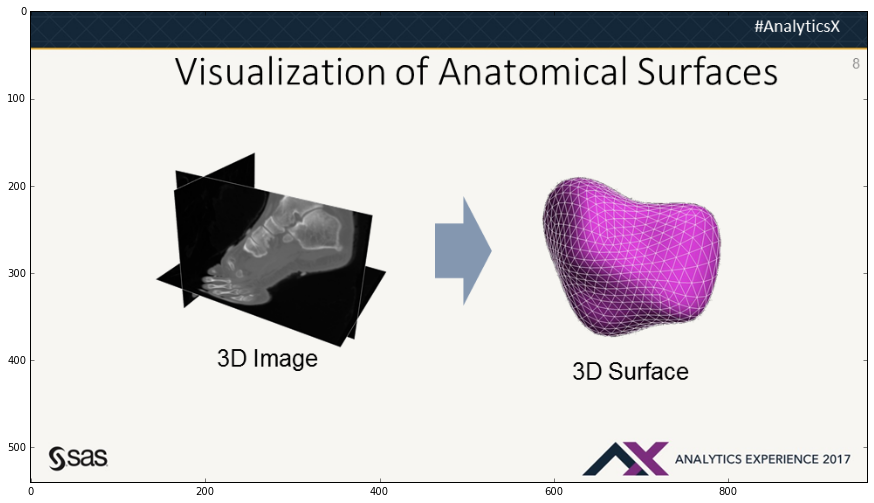

In [17]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 8)

# Build Surfaces from the Images

In [18]:
# Call the build surface action
vertices = s.CASTable('vertices', replace=True)
faces = s.CASTable('faces', replace=True)

vhp.biomedimage.buildsurface(images=dict(table=vhp),
                             thresholds=[dict(low=-157, high=1706), dict(low=136, high=1706)],
                             smoothing=dict(iterations=3),
                             outputVertices=vertices,
                             outputFaces=faces)

NOTE: Processed 3 images from Cloud Analytic Services table VHP.


[Surfaces]

    Surface Identifier  Image Identifier  Low Threshold  High Threshold  \
 0                   2                 1         -157.0          1706.0   
 1                   5                 1          136.0          1706.0   
 2                   4                 2         -157.0          1706.0   
 3                   9                 2          136.0          1706.0   
 4                   6                 3         -157.0          1706.0   
 5                  13                 3          136.0          1706.0   
 
    Number of Vertices  Number of Faces  
 0                9751            13662  
 1                8335            11608  
 2               37715            73518  
 3               82417           160626  
 4              137129           273662  
 5              162498           323690  

+ Elapsed: 35.3s, user: 49s, sys: 1.19s, mem: 102mb

# Fetch & Visualize the Surfaces from the Ankle Image (Using Mayavi)

## Fetch ankle surface

In [19]:
surf_ids = [6, 13]

fetched_vertices = vertices.query('_surfaceId_ = %s or _surfaceId_ = %s' % 
                                  (surf_ids[0], surf_ids[1])).sort_values('_id_').to_frame()
fetched_faces = faces.to_frame()

## Visualizing the Surfaces

In [20]:
for surf_id in surf_ids:
    vertices = fetched_vertices[fetched_vertices._surfaceId_ == surf_id]
    faces = fetched_faces[fetched_faces._surfaceId_ == surf_id]
    x = vertices.ix[:, ['_x_']]
    y = vertices.ix[:, ['_y_']]
    z = vertices.ix[:, ['_z_']]
    flist = faces.ix[:, ['_v1_', '_v2_', '_v3_']]
    rgb = (255, 255, 255)
    op = 1
    if (surf_id == surf_ids[0]):
        rgb = (198,134,66)
        op = 0.75
    mlab.triangular_mesh(x, y, z, flist, color=tuple([c / 255 for c in rgb]), opacity=op)
mlab.show()

# Save Biomedical Images in Metaimage Format

In [21]:
# Save images
# Provide the table to be saved and the column name containing image paths
s.image.saveimages(images=dict(table=vhp, path='_path_'),
                   subdirectory='SaveDemo',
                   type='mha')

NOTE: Saved 3 images from Cloud Analytic Services table VHP into /dept/fvcc/BMIData/DemoData/LungNoduleClassification/SaveDemo/.


+ Elapsed: 0.793s, user: 0.572s, sys: 0.013s, mem: 8.15mb

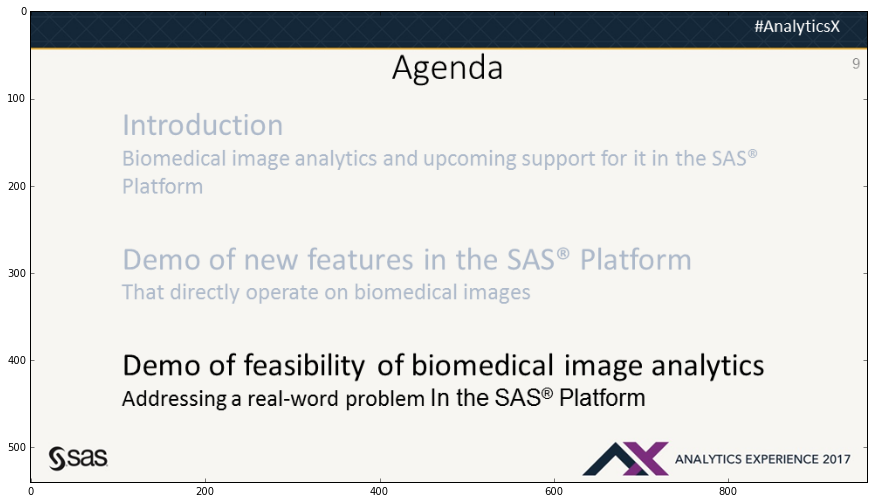

In [22]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 9)

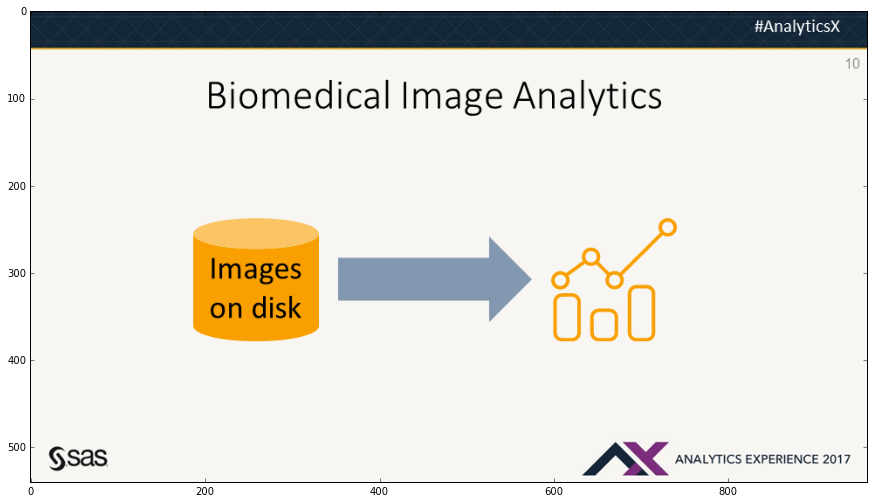

In [23]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 10)

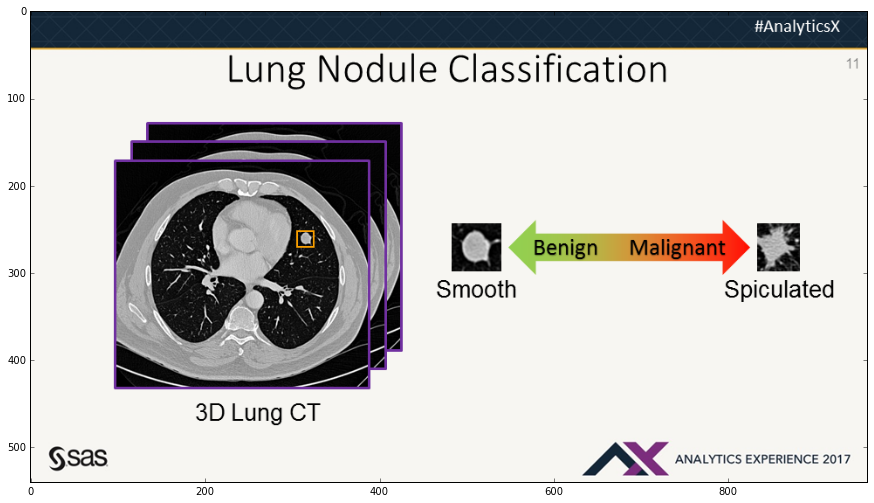

In [24]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 11)

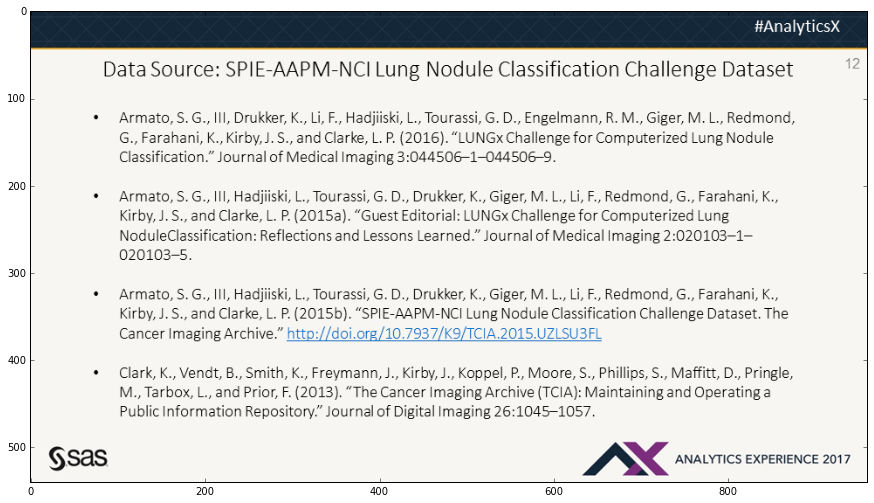

In [25]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 12)

# Load Example Patient Image with Malignant Lung Nodule (DICOM)

## Load the DICOM series of the patient as a 3D image

In [26]:
pid = "CT-Training-LC009"

example_medical = s.CASTable('exampleMedical', replace=True)

s.image.loadimages(path='%s%s%s' % (lcdemo_path, 'TrainDataOriginal/', pid),
                   casout=example_medical,
                   addcolumns=['width', 'height', 'depth', 'channeltype'],
                   recurse=True,
                   series=dict(dicom=True),
                   decode=True)

NOTE: Loaded 1 image from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataOriginal/CT-Training-LC009 into Cloud Analytic Services table exampleMedical.


+ Elapsed: 3.2s, user: 2.02s, sys: 0.675s, mem: 426mb

## Fetch the Image

In [27]:
example_rows = example_medical.to_frame()

# Display the Example Image

In [28]:
display(example_rows[['_channelType_', '_width_', '_height_', '_depth_']])

medical_dimensions = example_rows['_dimension_']
medical_formats = example_rows['_channelType_']
medical_binaries = example_rows['_image_']
medical_resolutions = example_rows['_resolution_']
medical_channel_types = example_rows['_channelType_']
medical_image_array = get_image_array(medical_binaries, medical_dimensions, medical_resolutions, medical_formats, 0)

sf = mlab.pipeline.scalar_field(medical_image_array)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes', slice_index=50, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes', slice_index=100, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', slice_index=100, colormap='gray')
mlab.show()

Selected Rows from Table EXAMPLEMEDICAL

  _channelType_  _width_  _height_  _depth_
0           16S      512       512      281

# Load & Fetch Radiologist Annotations of All Patients

## Load the CSV file with Annotations

In [29]:
train_labels = s.CASTable('trainlabels', replace=True)

s.load_path('%s%s' % (lcdemo_subdir, 'trainAnnotations.csv'),
            importoptions=dict(filetype='csv', getnames=True),
            casout=train_labels)

CASTable('TRAINLABELS', caslib='lcdemo')

## Fetch Table Contents

In [30]:
fetched_labels = train_labels.sort_values('PatientID').to_frame()
n_patients = len(fetched_labels)
display(fetched_labels)

Selected Rows from Table TRAINLABELS

           PatientID  NoduleX  NoduleY  NoduleZ  NoduleW  NoduleH  Diagnosis
0  CT-Training-BE001    396.0    288.0    169.0     12.0     12.0     benign
1  CT-Training-BE007    371.0    190.0    194.0     29.0     32.0     benign
2  CT-Training-LC002    132.0    352.0     70.0     14.0     14.0  malignant
3  CT-Training-LC003    365.0    314.0     70.0     19.0     19.0  malignant
4  CT-Training-LC009    129.0    279.0     63.0     39.0     43.0  malignant
5        LUNGx-CT002    311.0    328.0    205.0     37.0     37.0     benign
6        LUNGx-CT003    359.0    359.0    146.0     31.0     31.0  malignant
7        LUNGx-CT009    165.0    200.0    164.0     19.0     19.0     benign
8        LUNGx-CT019    114.0    345.0    131.0     36.0     36.0  malignant
9        LUNGx-CT024     97.0    274.0    197.0     20.0     20.0     benign

## Extract the Annotations for Later Use

In [31]:
patient_ids = fetched_labels['PatientID']
X = fetched_labels['NoduleX']
Y = fetched_labels['NoduleY']
W = fetched_labels['NoduleW']
H = fetched_labels['NoduleH']
Z = fetched_labels['NoduleZ'].copy()
diagnosis = fetched_labels['Diagnosis']

# Load All Patient DICOM Slices & Metadata

In [32]:
orig_medical = s.CASTable('origMedical', replace=True)

s.image.loadimages(path='%s%s' % (lcdemo_path, 'TrainDataOriginal/'),
                   casout=orig_medical,
                   addcolumns=['width', 'height', 'depth', 'channeltype', 'position', 'orientation', 'spacing'],
                   recurse=True,
                   labellevels=1,
                   decode=True)

NOTE: Loaded 3374 images from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataOriginal/ into Cloud Analytic Services table origMedical.


+ Elapsed: 1.01e+03s, user: 969s, sys: 24.3s, mem: 21.6mb

# Fetch & Display Example Slices of a Patient With Correct Position & Orientation

## Fetch Example Slices for a Patient

In [33]:
n_slices = 3
fetched_rows = orig_medical.query("_label_ = '%s'" % pid).head(n_slices)

## Display the Slices in the Patient Coordinate System

In [34]:
medical_dimensions = fetched_rows["_dimension_"]
medical_formats = fetched_rows["_channelType_"]
medical_binaries = fetched_rows["_image_"]
medical_resolutions = fetched_rows["_resolution_"]
medical_channel_types = fetched_rows["_channelType_"]
medical_spacings = fetched_rows["_spacing_"]
medical_positions = fetched_rows["_position_"]
medical_orientations = fetched_rows["_orientation_"]
for i in range(n_slices):
    display_slice_3d(medical_binaries, medical_dimensions, medical_resolutions, medical_formats,
                     medical_positions, medical_orientations, medical_spacings, (0, 1, 2), i, 0, 1)
mlab.show()

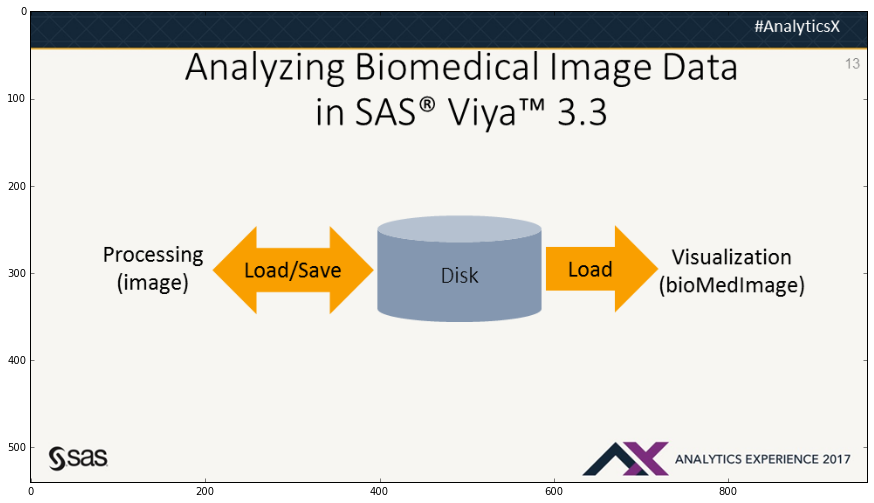

In [35]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 13)

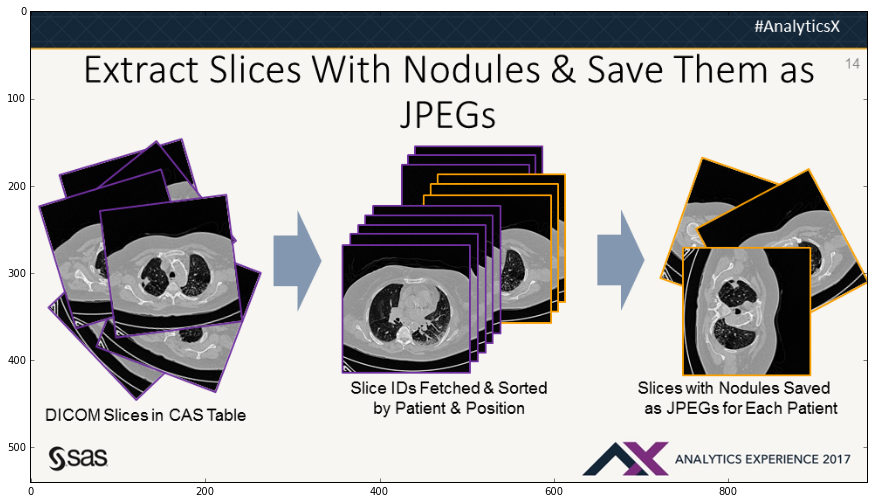

In [36]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 14)

## Fetch Slice IDs, Paths, Labels, and Geometry Metadata

In [37]:
fetched_rows = orig_medical[['_id_', '_path_', '_label_', '_position_', '_orientation_', '_spacing_']].to_frame()
image_ids = fetched_rows['_id_']
image_paths = fetched_rows['_path_']
image_labels = fetched_rows['_label_']
image_positions = fetched_rows['_position_']
image_orientations = fetched_rows['_orientation_']
image_spacing = fetched_rows['_spacing_']

## Process Each Patient

In [38]:
swat.options.print_messages = False

delta_z = 5

print('Sorting slice ids & saving %s nodule slices of ...' % (2 * delta_z + 1), flush=True)

for psn in range(len(patient_ids)):
    print(patient_ids[psn])
    
    # Sort the slices according to position
    sorted_inds, _ = sort_label_ids_by_position(image_ids, image_paths, image_labels, image_positions, image_orientations, patient_ids[psn])
    where_clause = '_id_ = %s' % sorted_inds[int(Z[psn]) - delta_z]
    
    # Save the slices around the location indicated by the radiologist as JPEGs. Save the patient label also.
    for i in range(-delta_z + 1, delta_z + 1):
        where_clause += ' or _id_ = %s' % sorted_inds[int(Z[psn]) + i]

    nodule_slices = s.CASTable('origMedical', replace=True, where=where_clause)
    s.image.saveimages(images=dict(table=nodule_slices, path='_path_'),
                       caslib=caslib_name,
                       subdirectory='%s%s' % (lcdemo_subdir, 'TrainDataJPG/'),
                       type='jpg',
                       labellevels=1)

print('Done', flush=True)

swat.options.print_messages = True

Sorting slice ids & saving 11 nodule slices of ...
CT-Training-BE001
CT-Training-BE007
CT-Training-LC002
CT-Training-LC003
CT-Training-LC009
LUNGx-CT002
LUNGx-CT003
LUNGx-CT009
LUNGx-CT019
LUNGx-CT024
Done


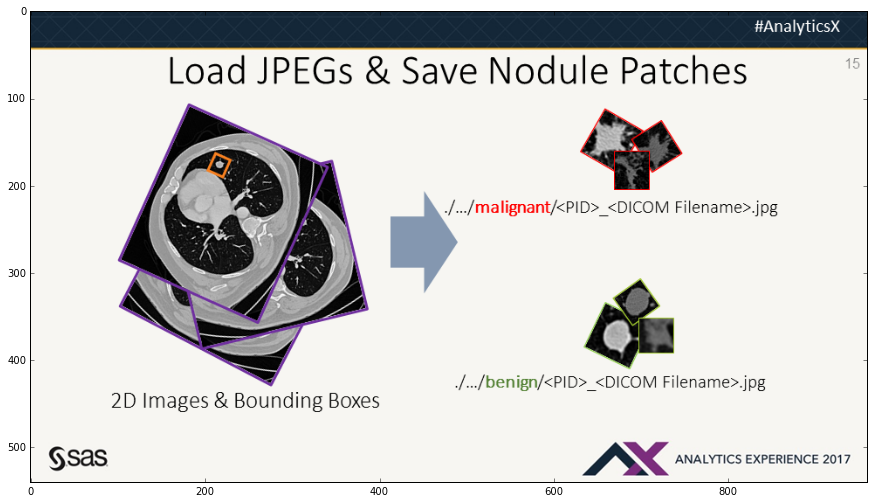

In [39]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 15)

## Process Each Patient

In [40]:
swat.options.print_messages = False

test_data_jpg_path = '%s%s' % (lcdemo_path, 'TrainDataJPG')

jpg_medical_in = s.CASTable('jpgMedical')
jpg_medical_out = s.CASTable('jpgMedical', replace=True)
crop_medical = s.CASTable('cropMedical', replace=True)

for i in range(n_patients):
    # Load the JPEGs for this patient
    print("Loading slices of %s ..." % patient_ids[i], flush=True)
    s.image.loadimages(path='%s%s%s' % (lcdemo_path, 'TrainDataJPG/', patient_ids[i]),
                       casout=jpg_medical_out)
    
    # Extract the nodule patch using radiologist annotation
    print("Extracting nodule patches ...", flush=True)
    s.image.processimages(imagetable=jpg_medical_in,
                          casout=crop_medical,
                          imagefunctions=[dict(functionoptions=dict(functiontype='get_patch',
                                                                    x=int(X[i]), y=int(Y[i]), 
                                                                    width=int(W[i]), height=int(H[i])))])
    
    # Save the patches of this patient in benign or maligant folder, with file names containing patient IDs and original
    print("Saving the patches in folder %s /..." % diagnosis[i], flush=True)
    series_crop_path = '%s%s%s' % (lcdemo_subdir, 'TrainDataJPGCrop/', diagnosis[i])
    s.image.saveimages(images=dict(table=crop_medical), caslib=caslib_name, 
                       subdirectory=series_crop_path, prefix='%s_' % patient_ids[i])

print('Done', flush=True)

swat.options.print_messages = True

Loading slices of CT-Training-BE001 ...
Extracting nodule patches ...
Saving the patches in folder benign /...
Loading slices of CT-Training-BE007 ...
Extracting nodule patches ...
Saving the patches in folder benign /...
Loading slices of CT-Training-LC002 ...
Extracting nodule patches ...
Saving the patches in folder malignant /...
Loading slices of CT-Training-LC003 ...
Extracting nodule patches ...
Saving the patches in folder malignant /...
Loading slices of CT-Training-LC009 ...
Extracting nodule patches ...
Saving the patches in folder malignant /...
Loading slices of LUNGx-CT002 ...
Extracting nodule patches ...
Saving the patches in folder benign /...
Loading slices of LUNGx-CT003 ...
Extracting nodule patches ...
Saving the patches in folder malignant /...
Loading slices of LUNGx-CT009 ...
Extracting nodule patches ...
Saving the patches in folder benign /...
Loading slices of LUNGx-CT019 ...
Extracting nodule patches ...
Saving the patches in folder malignant /...
Loading sl

# Load All Nodule Patches and Corresponding Diagnosis Labels; Display Examples

## Load All Nodule Patches

In [41]:
nodules = s.CASTable('nodules', replace=True)

s.image.loadImages(casout=nodules,
                   path='%s%s' % (lcdemo_path, 'TrainDataJPGCrop/'),
                   recurse=True,
                   labellevels=1,
                   decode=True)

NOTE: Loaded 110 images from /dept/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataJPGCrop/ into Cloud Analytic Services table nodules.


+ Elapsed: 1.78s, user: 1.38s, sys: 0.11s, mem: 2.93mb

## Display

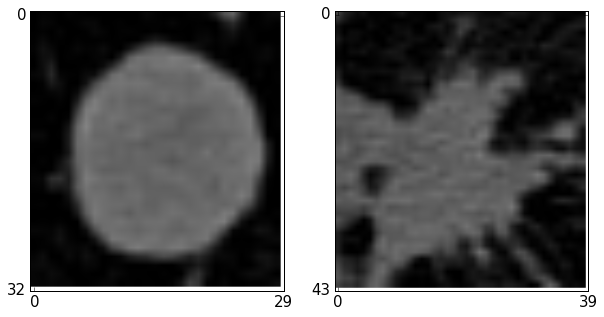

In [42]:
display_image_pair_from_table(nodules, 3, 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'), 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'))

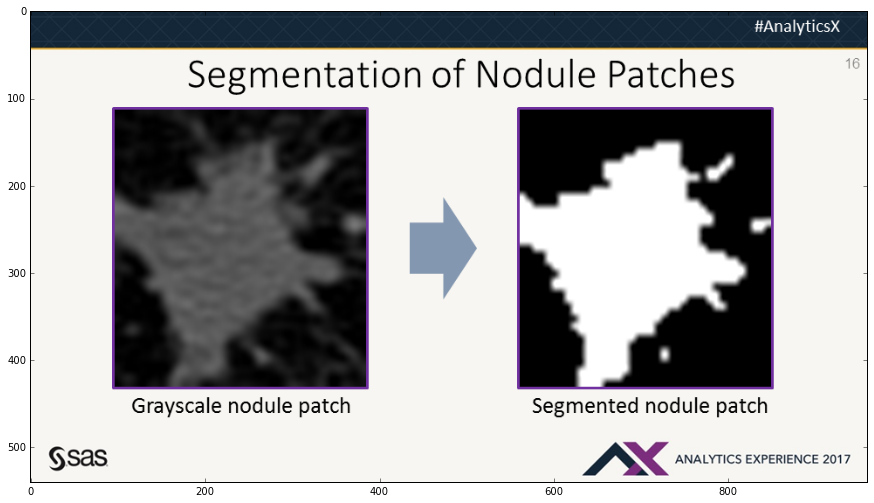

In [43]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 16)

## Call Smoothing and Thresholding via `processimages` Action

In [44]:
masks = s.CASTable('masks', replace=True)

nodules_in = s.CASTable('nodules')

s.image.processimages(casout=masks,
                      imagetable=nodules_in,
                      imagefunctions=[{'options': {'functiontype': 'convert_color'}}, #change color space to grayscale
                                      {'options': {'functiontype': 'bilateral_filter', #noise reduction
                                                   'diameter': 13, 'sigmacolor': 30, 'sigmaspace': 30}},
                                      {'options': {'functiontype': 'threshold', #image binarization
                                                   'type': 'OTSU', 'value': 125}}],
                      copyvars=['_path_', '_label_'],
                      decode=True)

NOTE: Table NODULES contains decompressed images.
NOTE: _path_ is already in the output table.
NOTE: _label_ is already in the output table.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masks.


+ Elapsed: 0.272s, user: 0.237s, sys: 0.037s, mem: 68.4mb

## Display

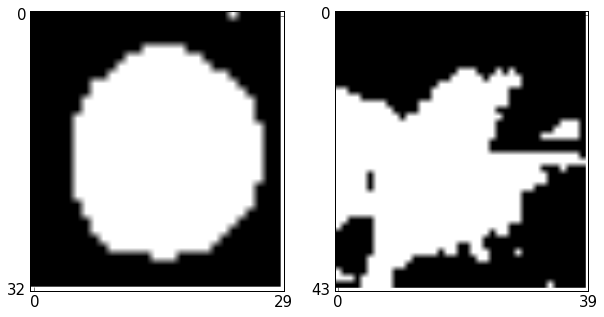

In [45]:
display_image_pair_from_table(masks, 1, 
                              "_path_ = '%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'), 
                              "_path_ = '%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'))

# Visualize Nodules Along with Ragiologist Annotated Slice, in 3D

In [46]:
# Function for visualizing the nodule of a patient, along with radiologist annotated slice, in 3D
def visualize_nodule(masks_table, psn):
    # Save the segmented nodule patches in order, as PNG images
    print('Saving segmented nodule slices with order embedded into file names ...', flush=True)
    crop_path = '%s%s' % (lcdemo_path, 'TrainDataJPGCrop/')
    plbl = patient_ids[psn]
    pdia = diagnosis[psn]
    sorted_ids, sorted_paths = sort_label_ids_by_position(image_ids, image_paths, image_labels,
                                                          image_positions, image_orientations, plbl)
    path_to_save = '%s%s/%s_%s.jpg' % (crop_path, pdia, plbl, 
                                       sorted_paths[int(Z[psn]) - delta_z + 1].rsplit('/', 1)[1][0:6])
    pgm = '''
          length _newPath_%s varchar(*);
          if _path_ = '%s' then
              _newPath_%s = '/001.tif';
    ''' % (str(psn), path_to_save, str(psn))
    count = 2
    
    for i in range(-delta_z + 2, delta_z + 1):
        path_to_save = '%s%s/%s_%s.jpg' % (crop_path, pdia, plbl, 
                                           sorted_paths[int(Z[psn]) + i].rsplit('/', 1)[1][0:6])
        pgm +=  "else if _path_ = '%s' then _newPath_%s = '/%03d.tif';" % (path_to_save, str(psn), count)
        count += 1

    pgm += "else _newPath_%s = '/dummy';" % str(psn)
    
    masks_table.append_computed_columns('_newPath_'+str(psn), pgm)
    s.image.saveimages(images=dict(table=masks_table, path='_newPath_'+str(psn)),
                       caslib=caslib_name, 
                       subdirectory='%s%s%s' % (lcdemo_subdir, 'ForVisualization/', plbl))
    
    # Load the nodule patches in order into a 3D image
    print('Loading the saved slides as a series into a 3D image ...', flush=True)
    s.image.loadimages(path='%s%s%s' % (lcdemo_path, 'ForVisualization/', plbl),
                       casout=dict(name='mask3D', replace=True),
                       series=dict(dicom=False))
    
    # Build the surface for the nodule
    print('Building 3D surface of the nodule ...', flush=True)
    
    vertices = s.CASTable('vertices', replace=True)
    faces = s.CASTable('faces', replace=True)
    
    resulttab = s.biomedimage.buildsurface(images='mask3D',
                                           intensities=[255],
                                           smoothing=dict(iterations=1),
                                           outputvertices=vertices,
                                           outputfaces=faces)
    display(resulttab)
    
    # Fetch the surface to the client side
    print('Fetching the surface ...', flush=True)
    fetched_vertices = vertices.sort_values('_id_').to_frame()
    fetched_faces = faces.to_frame()
    vertices = fetched_vertices[fetched_vertices._surfaceId_ == 2]
    faces = fetched_faces[fetched_faces._surfaceId_ == 2]
    x = vertices[['_x_']]
    y = vertices[['_y_']]
    z = vertices[['_z_']]
    flist = faces[['_v1_', '_v2_', '_v3_']]
    
    # Fetch the radiologist annotated slice and its metadata
    print('Fetching radiologist annotated slice and metadata ...', flush=True)
    slice_path = sorted_paths[int(Z[psn])]
    
    fetched_rows = s.CASTable('origMedical').query("_path_ = '%s'" % slice_path).to_frame()
    slice_image = fetched_rows['_image_']
    slice_dimension = fetched_rows['_dimension_']
    slice_resolution = fetched_rows['_resolution_']
    slice_format = fetched_rows['_channelType_']
    slice_position = fetched_rows['_position_']
    slice_orientation = fetched_rows['_orientation_']
    slice_spacing = fetched_rows['_spacing_']

    # Linearly transform the surface to match the slice"s coordinate system
    print('Linearly transforming the surface into the same coordinate system as the slice ...', flush=True)
    V = np.vstack((np.array(x).T, np.array(y).T, np.array(z).T))
    C = np.array([X[psn], Y[psn], -delta_z])
    C.shape = (3, 1)
    O = np.array(struct.unpack('=3d', slice_position[0]))
    O.shape = (3, 1)
    S = np.array(struct.unpack('=3d', slice_spacing[0]))
    S = np.diag(S)
    R = np.array(struct.unpack('=9d', slice_orientation[0]))
    R.shape = (3, 3)
    P = O + np.matmul(R, np.matmul(S, V+C))
    
    return (slice_image, slice_dimension, slice_resolution, slice_format, 
            slice_position, slice_orientation, slice_spacing, P, flist)

# Prepare for Visualizations

In [47]:
swat.options.print_messages = False
sib, sdb, srb, sfb, spb, sob, ssb, Pb, flistb = visualize_nodule(masks, 1)
sim, sdm, srm, sfm, spm, som, ssm, Pm, flistm = visualize_nodule(masks, 4)
swat.options.print_messages = True

Saving segmented nodule slices with order embedded into file names ...
Loading the saved slides as a series into a 3D image ...
Building 3D surface of the nodule ...


[Surfaces]

    Surface Identifier  Image Identifier  Low Threshold  High Threshold  \
 0                   2                 1          255.0           255.0   
 
    Number of Vertices  Number of Faces  
 0                2093             3656  

+ Elapsed: 23s, user: 22.9s, sys: 0.05s, mem: 70.5mb

Fetching the surface ...
Fetching radiologist annotated slice and metadata ...
Linearly transforming the surface into the same coordinate system as the slice ...
Saving segmented nodule slices with order embedded into file names ...
Loading the saved slides as a series into a 3D image ...
Building 3D surface of the nodule ...


[Surfaces]

    Surface Identifier  Image Identifier  Low Threshold  High Threshold  \
 0                   2                 1          255.0           255.0   
 
    Number of Vertices  Number of Faces  
 0                5302             9400  

+ Elapsed: 45.6s, user: 45.4s, sys: 0.247s, mem: 70.5mb

Fetching the surface ...
Fetching radiologist annotated slice and metadata ...
Linearly transforming the surface into the same coordinate system as the slice ...


# Visualize a Benign Nodule

In [48]:
display_slice_3d(sib, sdb, srb, sfb, spb, sob, ssb, (0, 1, 2), 0, 0, 1)
mlab.triangular_mesh(Pb[0, :], Pb[1, :], Pb[2, :], flistb, color=tuple([c/255 for c in (0, 255, 0)]), opacity=0.5)
mlab.show()

# Visualize a Malignant Nodule

In [49]:
display_slice_3d(sim, sdm, srm, sfm, spm, som, ssm, (0, 1, 2), 0, 0, 1)
mlab.triangular_mesh(Pm[0, :], Pm[1, :], Pm[2, :], flistm, color=tuple([c/255 for c in (255, 0, 0)]), opacity=0.5)
mlab.show()

# Resample All Patches to 32x32

In [50]:
# Calling processImages
common_w = 32
common_h = 32

masks_scaled = s.CASTable('masksScaled', replace=True)

s.image.processimages(imagetable='masks', 
                      casout=masks_scaled,
                      imagefunctions=[dict(functionoptions=dict(functiontype='resize', width=common_w, 
                                                                height=common_h)),
                                      dict(functionoptions=dict(functiontype='threshold', type='binary', 
                                                                value=128))],
                      copyvars=['_path_', '_label_'],
                      decode=True)

NOTE: Table MASKS contains decompressed images.
NOTE: _path_ is already in the output table.
NOTE: _label_ is already in the output table.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksScaled.


+ Elapsed: 0.13s, user: 0.097s, sys: 0.035s, mem: 68.6mb

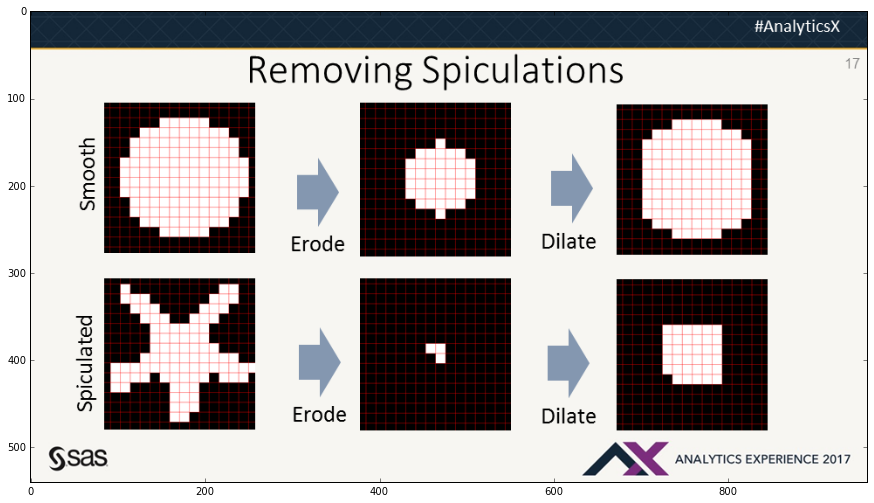

In [51]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 17)

## Erosion and Dilation using `processimages`

In [52]:
masks_final = s.CASTable('masksFinal', replace=True)
masks_scaled_in = s.CASTable('masksScaled')

s.image.processimages(imagetable=masks_scaled_in, 
                      casout=masks_final,
                      imagefunctions=[dict(functionoptions=dict(functiontype='morphology', method='erode',
                                                                kernelwidth=3, kernelheight=3)),
                                      dict(functionoptions=dict(functiontype='morphology', method='erode',
                                                                kernelwidth=3, kernelheight=3)),
                                      dict(functionoptions=dict(functiontype='morphology', method='erode',
                                                                kernelwidth=3, kernelheight=3)),
                                      dict(functionoptions=dict(functiontype='morphology', method='dilate',
                                                                kernelwidth=3, kernelheight=3)),
                                      dict(functionoptions=dict(functiontype='morphology', method='dilate',
                                                                kernelwidth=3, kernelheight=3)),
                                      dict(functionoptions=dict(functiontype='morphology', method='dilate',
                                                                kernelwidth=3, kernelheight=3))],
                      copyvars=['_path_', '_label_'],
                      decode=True)

NOTE: Table MASKSSCALED contains decompressed images.
NOTE: _path_ is already in the output table.
NOTE: _label_ is already in the output table.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksFinal.


+ Elapsed: 0.134s, user: 0.102s, sys: 0.035s, mem: 68.4mb

## Display

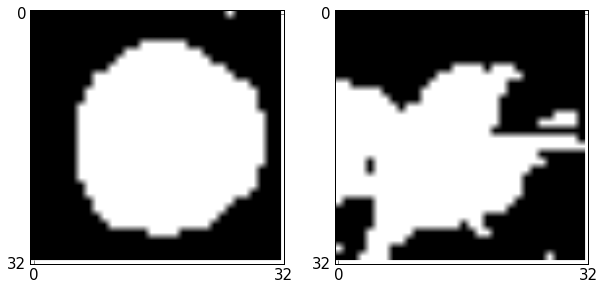

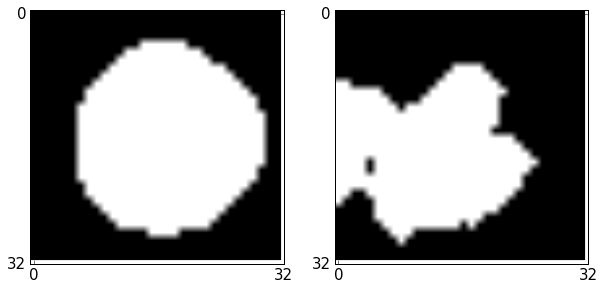

In [53]:
display_image_pair_from_table(masks_scaled, 1, 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'), 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'))
display_image_pair_from_table(masks_final, 1, 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/benign/CT-Training-BE007_000103.jpg'), 
                              "_path_='%s%s'" % (lcdemo_path, 'TrainDataJPGCrop/malignant/CT-Training-LC009_000013.jpg'))

# Convert Before & After Images to Wide Format

## Convert Before & After Images to Color

In [54]:
masks_scaled_color = s.CASTable('masksScaledColor', replace=True)
masks_final_color = s.CASTable('masksFinalColor', replace=True)
masks_final_in = s.CASTable('masksFinal')

s.image.processimages(imagetable=masks_scaled_in, 
                       casout=masks_scaled_color,
                       imagefunctions=[dict(functionoptions=dict(functiontype='convert_color', type='gray2color'))],
                       copyvars=['_path_', '_label_'],
                       decode=True)

s.image.processimages(imagetable=masks_final_in, 
                      casout=masks_final_color,
                      imageFunctions=[dict(functionoptions=dict(functiontype='convert_color', type='gray2color'))],
                      copyvars=['_path_', '_label_'],
                      decode=True)

NOTE: Table MASKSSCALED contains decompressed images.
NOTE: _path_ is already in the output table.
NOTE: _label_ is already in the output table.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksScaledColor.
NOTE: Table MASKSFINAL contains decompressed images.
NOTE: _path_ is already in the output table.
NOTE: _label_ is already in the output table.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksFinalColor.


+ Elapsed: 0.119s, user: 0.091s, sys: 0.031s, mem: 68.8mb

## Convert Before & After Images to Wide Format

In [55]:
masks_scaled_flat = s.CASTable('masksScaledFlat', replace=True)
masks_final_flat = s.CASTable('masksFinalFlat', replace=True)
masks_scaled_color_in = s.CASTable('masksScaledColor')
masks_final_color_in = s.CASTable('masksFinalColor')

s.image.flattenimagetable(imagetable=masks_scaled_color_in,
                          casout=masks_scaled_flat,
                          width=common_w,
                          height=common_h)

s.image.flattenimagetable(imagetable=masks_final_color_in, 
                          casout=masks_final_flat,
                          width=common_w,
                          height=common_h)

NOTE: Table MASKSSCALEDCOLOR contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved to the Cloud Analytic Services table masksScaledFlat.
NOTE: Table MASKSFINALCOLOR contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved to the Cloud Analytic Services table masksFinalFlat.


+ Elapsed: 0.155s, user: 0.107s, sys: 0.05s, mem: 73.2mb

## Fetch Sample Rows and Display

In [56]:
fetched_flat = masks_scaled_flat.head(3)


display(HTML("<h3>BEFORE morphological operations</h3>"))

last_slash = fetched_flat['_path_'][0].rfind('/')
fetched_flat['_path_'] = fetched_flat['_path_'].str[last_slash:]

midc = "c1017"

display(fetched_flat[['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']],
               headers='keys', tablefmt='psql')

fetched_flat = masks_final_flat.head(3)

display(HTML("<h3>AFTER morphological operations</h3>"))

fetched_flat['_path_'] = fetched_flat['_path_'].str[last_slash:]

display(fetched_flat[['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']],
               headers='keys', tablefmt='psql')

Selected Rows from Table MASKSSCALEDFLAT

                          _path_   c1   c2   c3  c1017  c3072    _label_
0  /CT-Training-LC003_000025.jpg  0.0  0.0  0.0  255.0    0.0  malignant
1  /CT-Training-LC003_000007.jpg  0.0  0.0  0.0  255.0  255.0  malignant
2  /CT-Training-LC002_000042.jpg  0.0  0.0  0.0    0.0    0.0  malignant

Selected Rows from Table MASKSFINALFLAT

                          _path_   c1   c2   c3  c1017  c3072    _label_
0  /CT-Training-LC003_000025.jpg  0.0  0.0  0.0  255.0    0.0  malignant
1  /CT-Training-LC003_000007.jpg  0.0  0.0  0.0    0.0  255.0  malignant
2  /CT-Training-LC002_000042.jpg  0.0  0.0  0.0    0.0    0.0  malignant

# Add Up the White Pixels in All Images & Fetch the Results

## Create the Program for the Sum of All Columns

In [57]:
pgm = 'c1'
for num in range(2, common_w * common_h * 3 + 1):
    pgm += ' + c%s' % num

## Fetch the Tables with #White Pixels in Each of the Slices Computed

In [58]:
masks_scaled_flat['nz'] = masks_scaled_flat.eval(pgm)
scaled_sum = masks_scaled_flat[['_path_', '_label_', 'nz']].head(1000)

masks_final_flat['nz'] = masks_final_flat.eval(pgm)
final_sum = masks_final_flat[['_path_', 'nz']].head(1000)

## Fetch Sample Rows and Display

In [59]:
display(HTML("<h3>BEFORE morphological operations</h3>"))
scaled_sum['_path_'] = scaled_sum['_path_'].str[last_slash:]
display(scaled_sum[['_path_', 'nz', '_label_']].head(3), headers='keys', tablefmt='psql')

display(HTML("<h3>AFTER morphological operations</h3>"))
final_sum['_path_'] = final_sum['_path_'].str[last_slash:]
display(final_sum[['_path_', 'nz']].head(3), headers='keys', tablefmt='psql')

Selected Rows from Table MASKSSCALEDFLAT

                          _path_        nz    _label_
0  /CT-Training-LC003_000025.jpg  262395.0  malignant
1  /CT-Training-LC003_000007.jpg  250920.0  malignant
2  /CT-Training-LC002_000042.jpg  207315.0  malignant

Selected Rows from Table MASKSFINALFLAT

                          _path_        nz
0  /CT-Training-LC003_000025.jpg  244035.0
1  /CT-Training-LC003_000007.jpg  225675.0
2  /CT-Training-LC002_000042.jpg  108630.0

# Compute Degree of Spiculation: Relative Amount of Pixels "Lost" During Morphological Operations

In [60]:
# Join the 2 tables on file path
joined_sum = pd.merge(scaled_sum, final_sum, on='_path_', suffixes=['s', 'f'])
fetched_spiculations = (joined_sum['nzs'] - joined_sum['nzf']) / joined_sum['nzs']
fetched_labels = joined_sum['_label_']
n_images = len(fetched_labels)
print(np.column_stack((fetched_spiculations, fetched_labels.T))[0:3, :])

[[0.06997084548104957 'malignant']
 [0.10060975609756098 'malignant']
 [0.47601476014760147 'malignant']]


# Plot the Distribution of Degree of Spiculation for Each Class

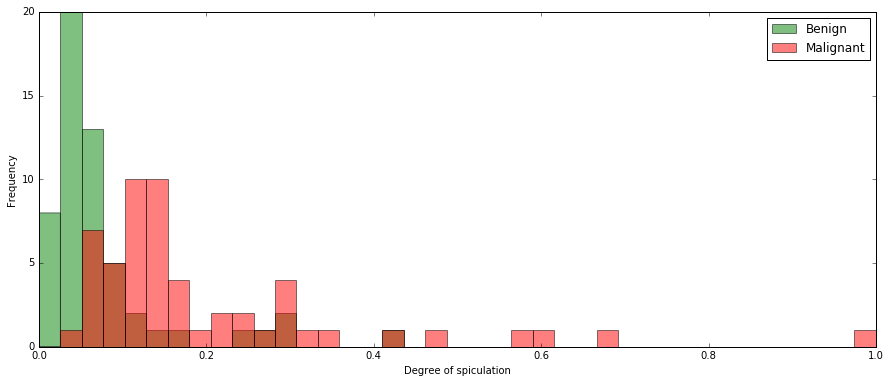

In [61]:
# Plot histograms for spiculation for each label
fig, ax = plt.subplots(figsize=(15, 6))

bar_width = 0.7
opacity = 0.5

bins = np.linspace(0, 1, 40)

inds = [i for i in range(n_images) if fetched_labels[i] == 'benign']
plt.hist(fetched_spiculations[inds], bins, alpha=opacity, label='Benign', color='g')

inds = [i for i in range(n_images) if fetched_labels[i] == 'malignant']
plt.hist(fetched_spiculations[inds], bins, alpha=opacity, label='Malignant', color='r')

plt.xlabel('Degree of spiculation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC Curve for the Metric & Calculate Optimal Threshold

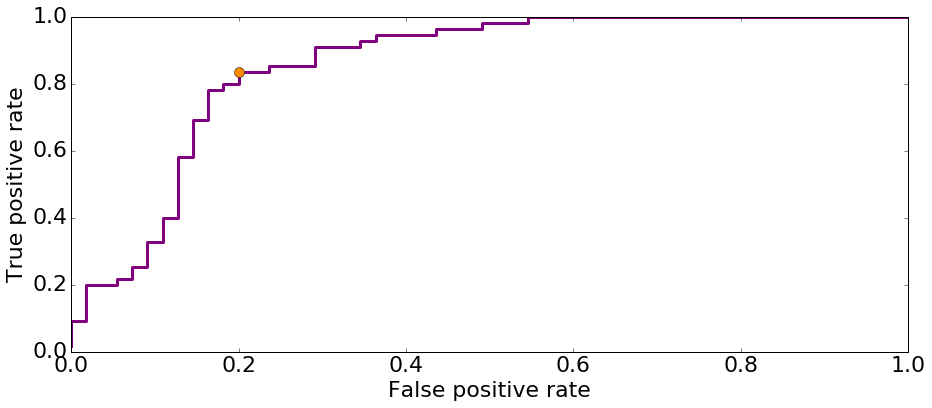

In [62]:
optt, fpr, tpr, thresholds = find_optimal_cutoff(fetched_labels, fetched_spiculations, 'malignant')

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(fpr, tpr, color='#800080', linewidth=3.0)

plt.plot([fpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]], 
         [tpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]],
         marker='o', color='#FF8C00', markersize=10)

matplotlib.rcParams.update({'font.size': 22})

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

display(HTML("<h3>Optimal spiculation cut off: %s" % optt[0] + "<h3>"))

# Assess the Metric Accuracy With k-Fold Cross Validation

In [63]:
n_folds = 10
kf = model_selection.KFold(n_splits=n_folds)

acc=[]
for train_index, test_index in kf.split(fetched_spiculations):
    ot, f, t, ts = find_optimal_cutoff(fetched_labels[train_index], fetched_spiculations[train_index], 'malignant')
    acc.extend([sum(1 for i in test_index if (fetched_spiculations[i] >  ot and fetched_labels[i] == 'malignant') or
                                             (fetched_spiculations[i] <= ot and fetched_labels[i] == 'benign')) / len(test_index) * 100])

display(HTML("<h3>Classification accuracy based on %s -fold cross-validation: %s" % (n_folds, np.mean(acc)) + "<h3>"))

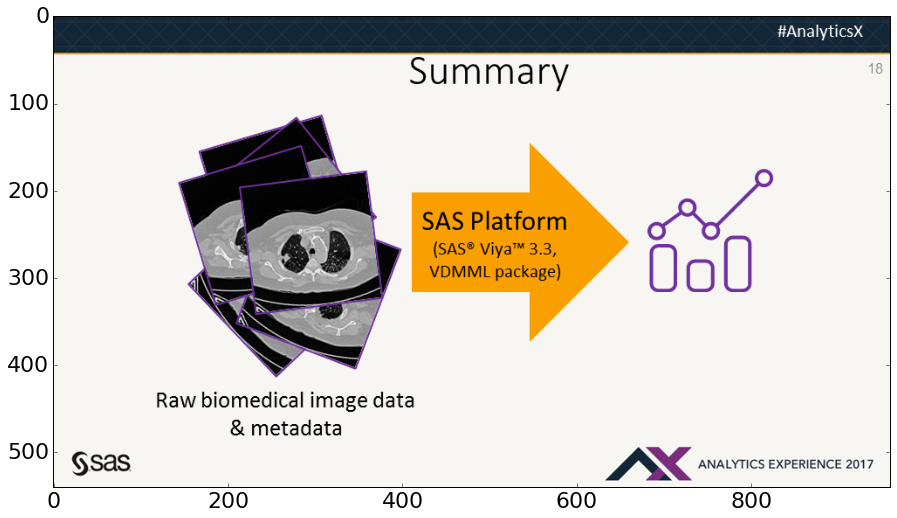

In [64]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 18)

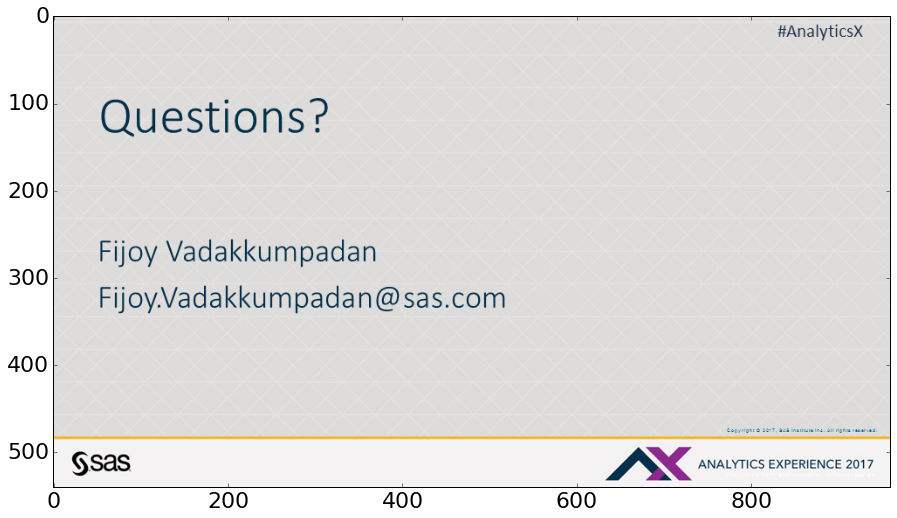

In [65]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 19)

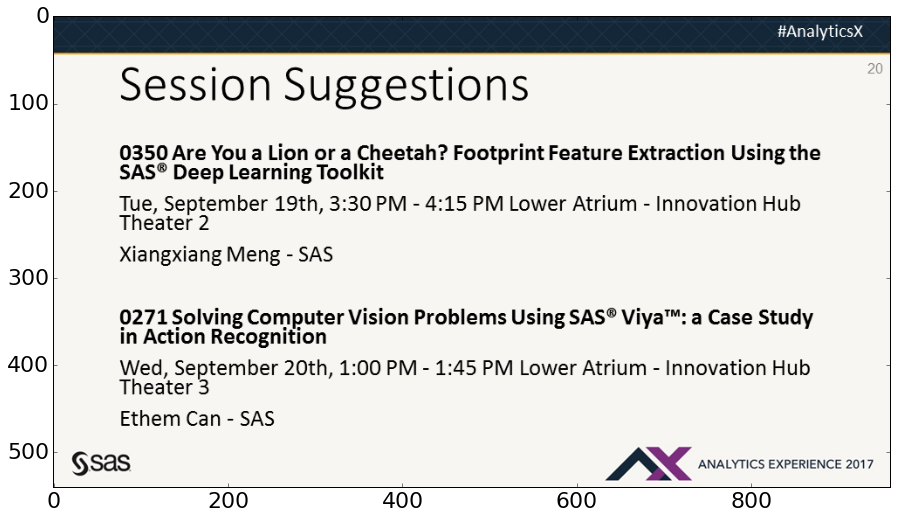

In [66]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 20)

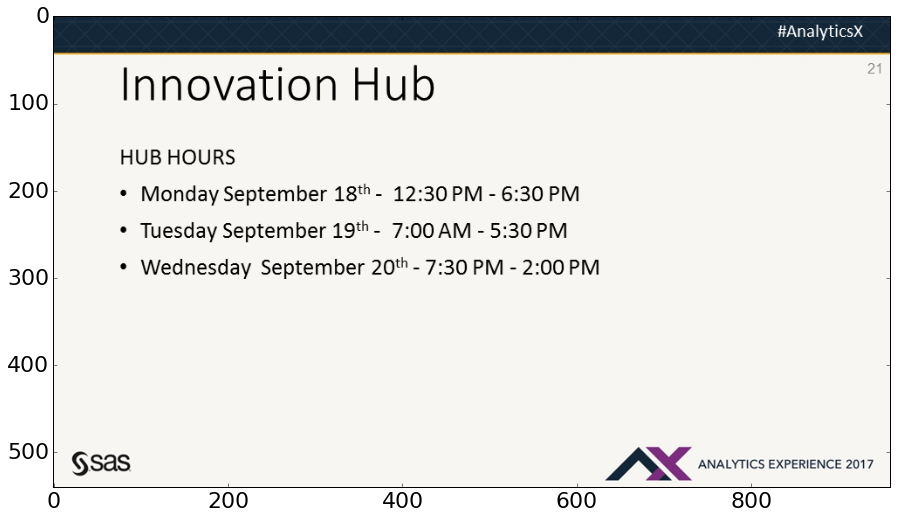

In [67]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 21)

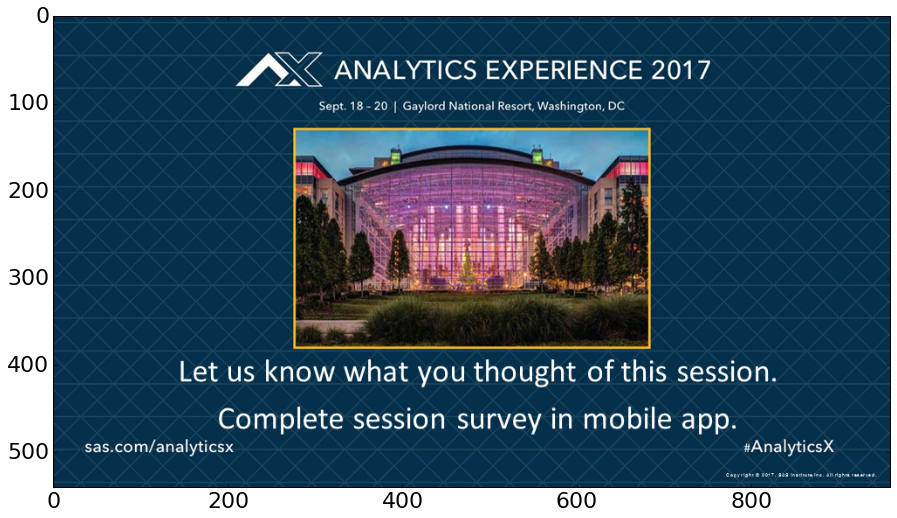

In [68]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 22)